**Basic RL Algoirhtms!** 

In this first notebook, we will look at Markov Decision Processes and some basic RL algorithms that can solve them! 
Some cells still need to be finished, leaving them as a challenge for you to solve! Some of these challenges are difficult, so don't worry if you get stuck. Answers are also available on a completed version of this notebook in the answers folder! Good luck! 

In [4]:
#Our imports
from Environments.maze import maze_game
import numpy as np
import scipy.signal
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt

A sensible first step when working on an RL problem, is taking a look at the MDP we are trying to solve (you can see the code for the env in Environments/maze.py). 

In [5]:
env = maze_game(difficulty='easy')
env.reset()
print('Observation Space: ',  env.observation_space)
print('Action Space: ', env.action_space)
print(env.maze)

Observation Space:  Discrete(25)
Action Space:  Discrete(4)
[['A' 'X' ' ' ' ' ' ']
 [' ' 'X' ' ' 'X' ' ']
 [' ' ' ' ' ' 'X' 'X']
 [' ' 'X' ' ' ' ' ' ']
 [' ' 'X' ' ' 'X' 'G']]


C:\Users\Adam\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Q-Learning! Lets start with a value-based method.  

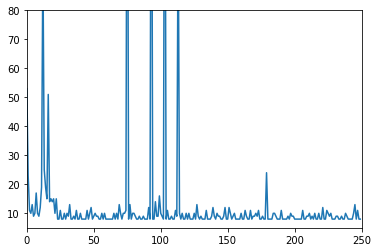

In [3]:
def epsilon_greedy_policy(state, q_table, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(4)
    return np.argmax(q_table[state])

class QLearningSolver():

    def __init__(self, env, policy):
        self.q_table = np.random.random((env.observation_space.n, env.action_space.n)) 
        self.lr = .1
        self.gamma = .98
        self.policy = policy
        self.env = env
        self.epsilon = .1

    def solve(self, num_episodes=500):
        steps = []
        for episodes in range(num_episodes):
            state = maze_env.reset()['state']
            done = False
            while not done:
                action = self.policy(state, self.q_table, self.epsilon)
                new_state, reward, done, _, _ = maze_env.step(action)
                #Q Learning update 
                self.q_table[state, action] += self.lr * (reward + self.gamma * np.max(self.q_table[new_state['state'], :]) - self.q_table[state, action])
                state = new_state['state']
            steps.append(self.env.steps)
        return steps

num_trails = 1
num_episodes = 250
trails = []
for i in range(num_trails):
    maze_env = maze_game('easy')
    q_solver = QLearningSolver(maze_env, epsilon_greedy_policy)
    trails.append(q_solver.solve(num_episodes))

plt.axis([0, num_episodes, 5, 80])
plt.plot(np.array(trails).mean(axis=0))

Lets take a closer look at what is going on here. 

C:\Users\Adam\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[['A' 'X' ' ' ' ' ' ']
 [' ' 'X' ' ' 'X' ' ']
 [' ' ' ' ' ' 'X' 'X']
 [' ' 'X' ' ' ' ' ' ']
 [' ' 'X' ' ' 'X' 'G']]


<AxesSubplot:>

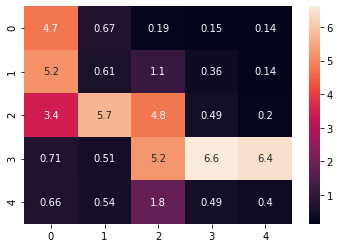

In [4]:
#Take the average value of each action at each state. 
state_values = np.mean(q_solver.q_table, axis=1)
state_values = state_values.reshape((int(np.sqrt(state_values.shape[0])),int(np.sqrt(state_values.shape[0]))))
print(env.maze)
sns.heatmap(state_values, annot=True)

In [5]:
class one_hot_maze(maze_game):
    def step(self, action):
        state, reward, done, _, _ = super().step(action)
        state_onehot = np.zeros(self.observation_space.n)
        state_onehot[state['state']] = 1
        return {'state': state_onehot}, reward, done, None, None
    
    def reset(self):
        state = super().reset()
        state_onehot = np.zeros(self.observation_space.n)
        state_onehot[state['state']] = 1
        return {'state': state_onehot}

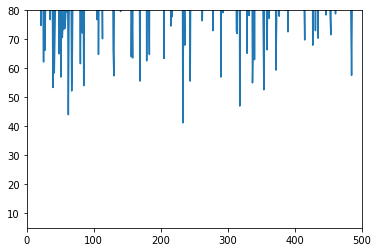

In [10]:
def softmax_policy(state, W):
    logits = np.dot(state['state'], W)
    softmax = np.exp(logits) / sum(np.exp(logits))
    action = np.random.choice(4, p=softmax)
    return action, softmax

class PolicyGradientSolver():

    def __init__(self, env, policy):
        self.W = np.random.random((env.observation_space.n, env.action_space.n)) 
        self.lr = .01
        self.gamma = .99
        self.policy = policy
        self.env = env

    def solve(self, num_episodes=500):
        steps = []
        for episodes in range(num_episodes):
            state = self.env.reset()
            rewards = []
            states = [state['state']]
            actions = []
            derivatives = []
            done = False
            while not done:
                action, probs = self.policy(state, self.W)
                probs = np.expand_dims(probs, 1)
                jacobian = np.diagflat(probs) - np.dot(probs, probs.T)
                derivatives.append(jacobian[action])
                actions.append(action)
                new_state, reward, done, _, _ = self.env.step(action)
                states.append(new_state['state'])
                rewards.append(reward)
                state = new_state
            steps.append(self.env.steps)
            states = np.array(states); actions = np.array(actions); derivatives = np.array(derivatives)
            gain = scipy.signal.lfilter([1], [1, float(-self.gamma)], np.array(rewards[::-1]), axis=0)[::-1]
            for i in range(derivatives.shape[0]):
                self.W[np.argmax(states[i]),:] += self.lr * derivatives[i] * gain[i]

        return steps

num_trails = 5
num_episodes = 500
trails = []
for i in range(num_trails):
    maze_env = one_hot_maze('easy')
    pq_solver = PolicyGradientSolver(maze_env, softmax_policy)
    trails.append(pq_solver.solve(num_episodes))

plt.axis([0, num_episodes, 5, 80])
plt.plot(np.array(trails).mean(axis=0))

[['A' 'X' ' ' ' ' ' ']
 [' ' 'X' ' ' 'X' ' ']
 [' ' ' ' ' ' 'X' 'X']
 [' ' 'X' ' ' ' ' ' ']
 [' ' 'X' ' ' 'X' 'G']]


C:\Users\Adam\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

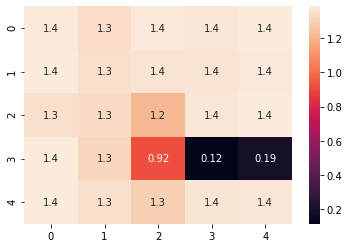

In [11]:
entropy = []
for i in range(pq_solver.env.observation_space.n):
    state = {'state': np.zeros(pq_solver.env.observation_space.n)}
    state['state'][i] = 1
    action, softmax = pq_solver.policy(state, pq_solver.W)
    entropy.append(scipy.stats.entropy(softmax))
entropy = np.array(entropy).reshape(int(np.sqrt(pq_solver.env.observation_space.n)),int(np.sqrt(pq_solver.env.observation_space.n)))
print(env.maze)
sns.heatmap(entropy, annot=True)

<ipython-input-19-d5cf42d13e5a>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  states = np.array(states); actions = np.array(actions); derivatives = np.array(derivatives)


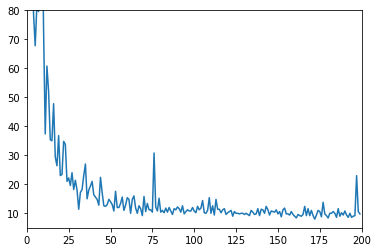

In [19]:
class PolicyGradientActorCriticSolver():

    def __init__(self, env, policy):
        self.W = np.random.random((env.observation_space.n, env.action_space.n)) 
        self.V = np.random.random((env.observation_space.n, 1)) 
        self.lr = .1
        self.gamma = .95
        self.policy = policy
        self.env = env
        self.value_lr = .1
        self.value_lambda = 0.99

    def solve(self, num_episodes=500):
        steps = []
        for episodes in range(num_episodes):
            state = self.env.reset()
            rewards = []
            states = [[state['state']]]
            actions = []
            derivatives = []
            done = False
            while not done:
                action, probs = self.policy(state, self.W)
                probs = np.expand_dims(probs, 1)
                jacobian = np.diagflat(probs) - np.dot(probs, probs.T)
                derivatives.append(jacobian[action])
                actions.append(action)
                new_state, reward, done, _, _ = self.env.step(action)
                states.append(new_state['state'])
                rewards.append(reward)
                state = new_state
            steps.append(self.env.steps)
            states = np.array(states); actions = np.array(actions); derivatives = np.array(derivatives)
            gain = scipy.signal.lfilter([1], [1, float(-self.gamma)], np.array(rewards[::-1]), axis=0)[::-1]
            for i in range(derivatives.shape[0]):
                self.W[np.argmax(states[i]),:] += self.lr * derivatives[i] * (gain[i] - np.dot(states[i], self.V)[0])

            #Simple gradient decent that takes advantage of the fact our state is one-hot
            for i in range(gain.shape[0]):
                self.V[np.argmax(states[i])] += self.value_lr * (gain[i] - np.dot(states[i], self.V)[0]) 
            self.value_lr *= self.value_lambda
        return steps

num_trails = 5
num_episodes = 200
trails = []
for i in range(5):
    maze_env = one_hot_maze('easy')
    ac_solver = PolicyGradientActorCriticSolver(maze_env, softmax_policy)
    trails.append(ac_solver.solve(num_episodes))

plt.axis([0, num_episodes, 5, 80])
plt.plot(np.array(trails).mean(axis=0))

[['A' 'X' ' ' ' ' ' ']
 [' ' 'X' ' ' 'X' ' ']
 [' ' ' ' ' ' 'X' 'X']
 [' ' 'X' ' ' ' ' ' ']
 [' ' 'X' ' ' 'X' 'G']]


C:\Users\Adam\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

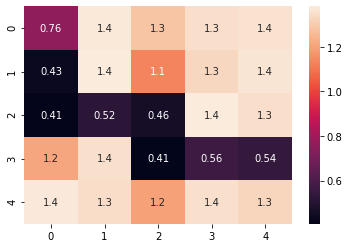

In [20]:
entropy = []
for i in range(ac_solver.env.observation_space.n):
    state = {'state': np.zeros(ac_solver.env.observation_space.n)}
    state['state'][i] = 1
    action, softmax = ac_solver.policy(state, ac_solver.W)
    entropy.append(scipy.stats.entropy(softmax))
entropy = np.array(entropy).reshape(int(np.sqrt(ac_solver.env.observation_space.n)),int(np.sqrt(ac_solver.env.observation_space.n)))
print(env.maze)
sns.heatmap(entropy, annot=True)

[['A' 'X' ' ' ' ' ' ']
 [' ' 'X' ' ' 'X' ' ']
 [' ' ' ' ' ' 'X' 'X']
 [' ' 'X' ' ' ' ' ' ']
 [' ' 'X' ' ' 'X' 'G']]


C:\Users\Adam\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

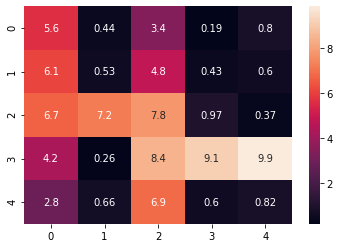

In [21]:
values = []
for i in range(ac_solver.env.observation_space.n):
    state = np.zeros(ac_solver.env.observation_space.n)
    state[i] = 1
    values.append(np.dot(state, ac_solver.V)[0])
values = np.array(values).reshape(int(np.sqrt(ac_solver.env.observation_space.n)),int(np.sqrt(ac_solver.env.observation_space.n)))
print(env.maze)
sns.heatmap(values, annot=True)

In [14]:
class one_hot_maze_action_mask(one_hot_maze):
    def step(self, action):
        state, reward, done, _, _ = super().step(action)
        #state = {'state': state}
        state['action_mask'] = self.get_action_mask()
        return state, reward, done, None, None
    
    def reset(self):
        state = super().reset()
        #state = {'state': state}
        state['action_mask'] = self.get_action_mask()
        return state
    
    def get_action_mask(self):
        action_mask = np.zeros(4)
        if self.y != 0:
            if self.maze[self.x, self.y-1] != 'X':
                action_mask[0] = 1
        if self.x != self.maze.shape[0]-1:
            if self.maze[self.x+1, self.y] != 'X':
                action_mask[1] = 1
        if self.y != self.maze.shape[1]-1:
            if self.maze[self.x, self.y+1] != 'X':
                action_mask[2] = 1
        if self.x != 0:
            if self.maze[self.x-1, self.y] != 'X':
                action_mask[3] = 1
        return action_mask

<ipython-input-12-0df3d24cb3b3>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  states = np.array(states); actions = np.array(actions); derivatives = np.array(derivatives)


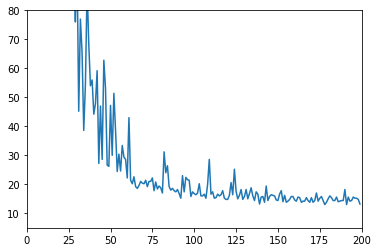

In [15]:
def softmax_policy_action_mask(state, W):
    logits = np.dot(state['state'], W)
    logits *= state['action_mask']
    softmax = np.exp(logits) / sum(np.exp(logits))
    action = np.random.choice(4, p=softmax)
    return action, softmax

num_trails = 5
num_episodes = 200
trails = []
for i in range(num_trails):
    maze_env = one_hot_maze_action_mask('hard')
    solver = PolicyGradientActorCriticSolver(maze_env, softmax_policy_action_mask)
    trails.append(solver.solve(num_episodes))

plt.axis([0, num_episodes, 5, 80])
plt.plot(np.array(trails).mean(axis=0))

C:\Users\Adam\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-12-0df3d24cb3b3>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  states = np.array(states); actions = np.array(actions); derivatives = np.array(derivatives)


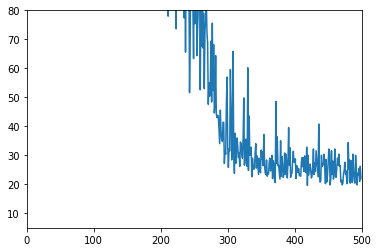

In [16]:
num_trails = 5
num_episodes = 500
trails = []
for i in range(num_trails):
    maze_env = one_hot_maze('very hard')
    solver = PolicyGradientActorCriticSolver(maze_env, softmax_policy)
    solver.lr = .05
    solver.gamma = .97
    trails.append(solver.solve(num_episodes))

plt.axis([0, num_episodes, 5, 80])
plt.plot(np.array(trails).mean(axis=0))

C:\Users\Adam\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-12-0df3d24cb3b3>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  states = np.array(states); actions = np.array(actions); derivatives = np.array(derivatives)


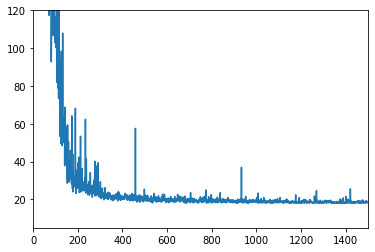

In [17]:
num_trails = 5
num_episodes = 1500
trails = []
for i in range(num_trails):
    maze_env = one_hot_maze_action_mask('very hard')
    solver = PolicyGradientActorCriticSolver(maze_env, softmax_policy_action_mask)
    solver.lr = .05
    solver.gamma = .97
    trails.append(solver.solve(num_episodes))

plt.axis([0, num_episodes, 5, 120])
plt.plot(np.array(trails).mean(axis=0))

In [ ]:
evaluation

C:\Users\Adam\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: name 'evaluation' is not defined

In [ ]:
def softmax_policy_action_mask_eval(state, W):
    logits = np.dot(state['state'], W)
    logits *= state['action_mask']
    softmax = np.exp(logits) / sum(np.exp(logits))
    action = np.argmax(softmax)
    return action, None

state = solver.env.reset()
solver.policy = softmax_policy_action_mask_eval
total_reward = 0
while not solver.env.done:
    action, probs = solver.policy(state, solver.W)
    new_state, reward, done, _, _ = solver.env.step(action)
    state = new_state
    total_reward += reward

print(solver.env.steps)
print(total_reward)

18
8.299999999999999


C:\Users\Adam\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
